# Aplicación de Multilayer Perceptron en clasificación de dibujos hechos a mano usando el conjunto de imágenes QuickDraw -10

- **Nombre:** Diego Valdés
- **Profesora:** Violeta Chang Camacho



## Objetivo de la tarea

El objetivo de esta tarea es entender y aplicar redes neuronales para clasificar imágenes. Así, en esta tarea el foco estará en la clasificación de dibujos hechos a mano usando el conjunto de imágenes QuickDraw

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm import trange
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim 
from sklearn.decomposition import PCA



## Extracción de los datos de QuickDraw-10 y QuickDraw-Animals
Se verifica que la carpeta contiene las siguientes carpetas y archivos:

* mapping.txt: Mapea las etiquetas a las clases.

* train.txt: Contiene las rutas a las imágenes de entrenamiento y sus respectivas etiquetas.

* test.txt: Contiene las rutas a las imágenes de prueba y sus respectivas etiquetas.

* images/: Carpeta con las imágenes de todos los dibujos.

In [2]:
# Ruta del archivo descomprimido
ruta_base10 = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-10"

print("Archivos dentro de QuickDraw-10:")
archivos = os.listdir(ruta_base10)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)


Archivos dentro de QuickDraw-10:
images
mapping.txt
test.txt
train.txt


In [3]:
# Ruta del archivo descomprimido
ruta_baseA = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-Animals"

print("Archivos dentro de QuickDraw-Animals:")
archivos = os.listdir(ruta_baseA)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)

Archivos dentro de QuickDraw-Animals:
mapping.txt
test_images
train_images


# Carga y estructura de los datos de Quickdraw-10


Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_train10.shape = (9834, 256): contiene 9834 imágenes de entrenamiento.

* y_train10.shape = (9834,): etiquetas correspondientes a X_train, con valores entre 0 y 9 (una por clase).

* X_test10.shape = (1166, 256): contiene 1166 imágenes de prueba.

* y_test10.shape = (1166,): etiquetas correspondientes a X_test.

In [4]:
# Para QuickDraw-10

etiquetas_quickdraw10 = {
    0: "sink",1: "castle",2: "lion",
    3: "teapot",4: "flashlight",5: "blackberry",
    6: "spreadsheet",7: "bandage", 8: "remote-control",9: "trombone"
}

In [5]:
IMG_SIZE = 256

def cargartxt(txt_path, base_dir):
    X = []
    y = []
    with open(txt_path, 'r') as f:
        lineas = f.readlines()
        for linea in tqdm(lineas, desc=f"Cargando {os.path.basename(txt_path)}"):
            ruta_rel, etiqueta = linea.strip().split()
            ruta_img = os.path.join(base_dir, ruta_rel)
            try:
                img = Image.open(ruta_img).convert("L").resize((IMG_SIZE, IMG_SIZE))
                img_np = np.array(img, dtype=np.float32) / 255.0  
                img_flat = img_np.flatten()  
                X.append(img_flat)
                y.append(int(etiqueta))
            except Exception as e:
                print(f"Error al leer {ruta_img}: {e}")
    return np.array(X), np.array(y)

BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-10"
X_train10, y_train10 = cargartxt(os.path.join(BASE_DIR, "train.txt"), BASE_DIR)
X_test10, y_test10 = cargartxt(os.path.join(BASE_DIR, "test.txt"), BASE_DIR)

print("Antes de PCA:")
print("X_train:", X_train10.shape, "y_train:", y_train10.shape)
print("X_test:", X_test10.shape, "y_test:", y_test10.shape)

# PCA reducción a 256 componentes
pca = PCA(n_components=256)
X_train10_pca = pca.fit_transform(X_train10)
X_test10_pca = pca.transform(X_test10)

print("Después de PCA:")
print("X_train_pca:", X_train10_pca.shape)
print("X_test_pca:", X_test10_pca.shape)


Cargando test.txt: 100%|██████████| 1166/1166 [00:12<00:00, 92.98it/s]


Antes de PCA:
X_train: (9834, 65536) y_train: (9834,)
X_test: (1166, 65536) y_test: (1166,)
Después de PCA:
X_train_pca: (9834, 256)
X_test_pca: (1166, 256)


# Carga y estructura de los datos de Quickdraw-Animals

Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_trainA.shape = (12000, 256): contiene 12000 imágenes de entrenamiento.

* y_trainA.shape = (12000,): etiquetas correspondientes a X_train, con valores entre 0 y 11 (una por clase).

* X_testA.shape = (2399, 256): contiene 2399 imágenes de prueba.

* y_testA.shape = (2399,): etiquetas correspondientes a X_test.

In [6]:
etiquetas_animals = {
        "sheep": 0, "bear": 1, "bee": 2, "cat": 3, "camel": 4,
        "cow": 5, "crab": 6, "crocodile": 7, "duck": 8, "elephant": 9,
        "dog": 10, "giraffe": 11
    }

In [7]:

def cargar_dataset_animals(path_dir):
    X = []
    y = []
    
    for clase in os.listdir(path_dir):
        carpeta_clase = os.path.join(path_dir, clase)
        if not os.path.isdir(carpeta_clase):
            continue
        label = etiquetas_animals.get(clase)
        if label is None:
            continue
        for archivo in os.listdir(carpeta_clase):
            archivo_path = os.path.join(carpeta_clase, archivo)
            try:
                img = Image.open(archivo_path).convert("L")  
                img = img.resize((256, 256))  
                img_np = np.array(img).flatten() 
                X.append(img_np)
                y.append(label)
            except:
                pass  

    X = np.array(X, dtype=np.float32) / 255.0  
    y = np.array(y, dtype=np.int64)
    return X, y


BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-Animals"

X_trainA, y_trainA = cargar_dataset_animals(os.path.join(BASE_DIR, "train_images"))
X_testA, y_testA = cargar_dataset_animals(os.path.join(BASE_DIR, "test_images"))

print("X_train:", X_trainA.shape, "y_train:", y_trainA.shape)
print("X_test:", X_testA.shape, "y_test:", y_testA.shape)


X_train: (12000, 65536) y_train: (12000,)
X_test: (2399, 65536) y_test: (2399,)


In [8]:

# Crear PCA con 256 componentes
pca = PCA(n_components=256)

# Ajustar PCA solo con entrenamiento y transformar ambos sets
X_trainA_pca = pca.fit_transform(X_trainA)
X_testA_pca = pca.transform(X_testA)

print("Después de PCA:")
print("X_trainA_pca:", X_trainA_pca.shape)
print("X_testA_pca:", X_testA_pca.shape)

Después de PCA:
X_trainA_pca: (12000, 256)
X_testA_pca: (2399, 256)


# Visualización de las imágenes



Para corroborar que las imágenes estan cargando correctamente se escogeran algunas y se mostrarán.

In [9]:
def mostrar_imagenes_random(X, y, cantidad=50, etiquetas_dict=None, titulo="Muestras Aleatorias"):
   
    idx = np.random.choice(len(X), size=cantidad, replace=False)
    imagenes = [X[i].reshape(256, 256) for i in idx]
    etiquetas = [y[i] for i in idx]

    filas = cantidad // 10
    fig, axes = plt.subplots(filas, 10, figsize=(20, 2.5 * filas))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imagenes[i], cmap='gray')
        ax.axis('off')
        label = etiquetas[i]
        label_str = etiquetas_dict[label] if etiquetas_dict else str(label)
        ax.set_title(f'Label: {label_str}')
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()


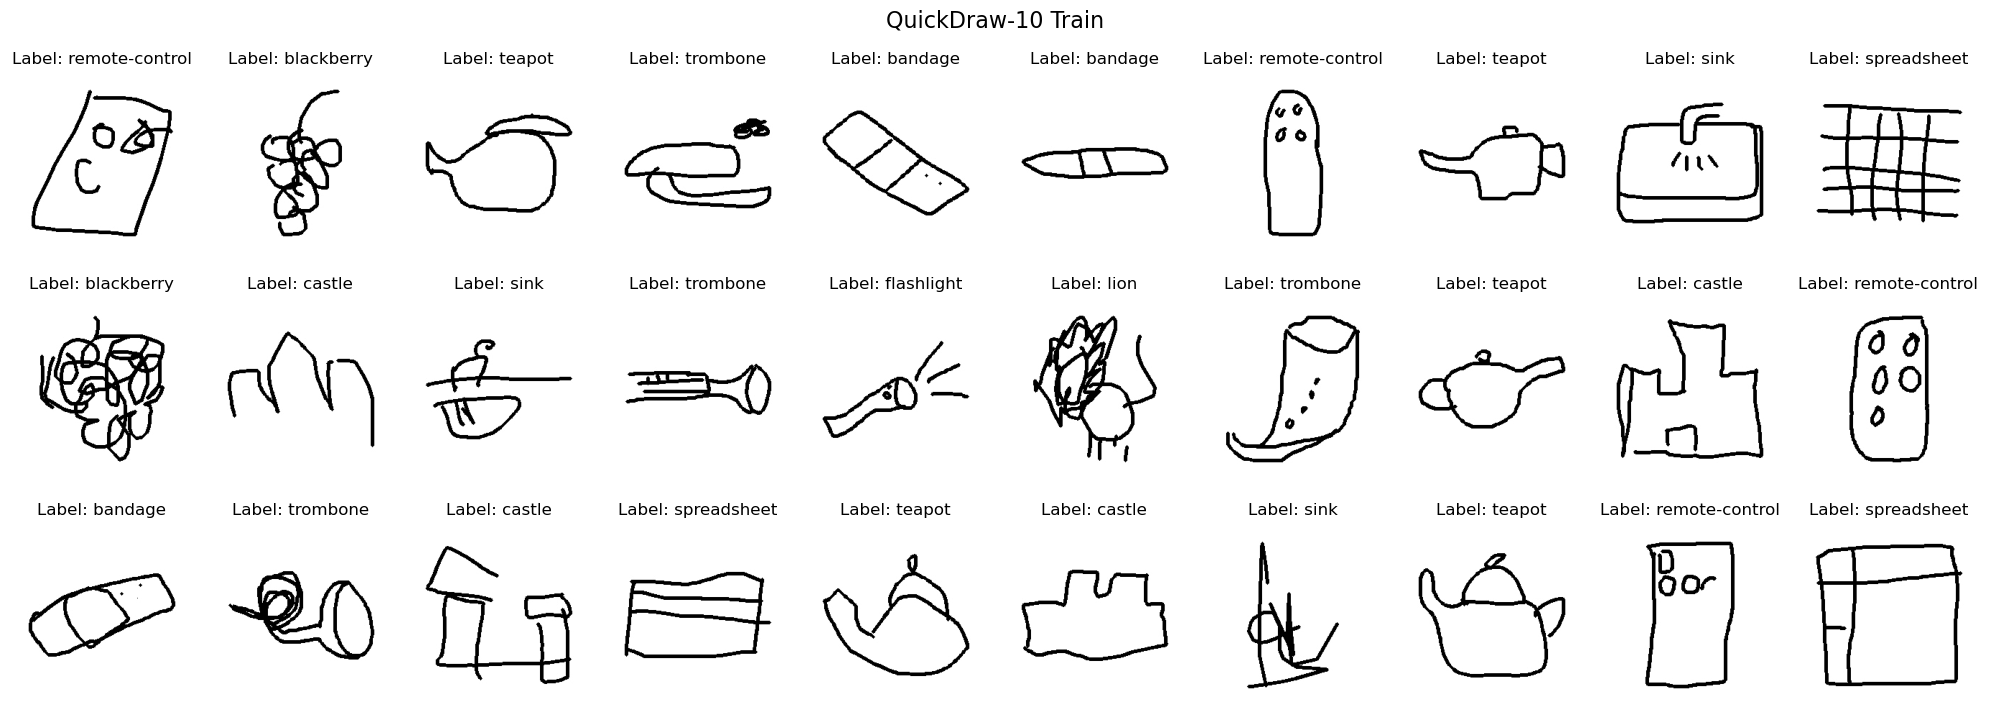

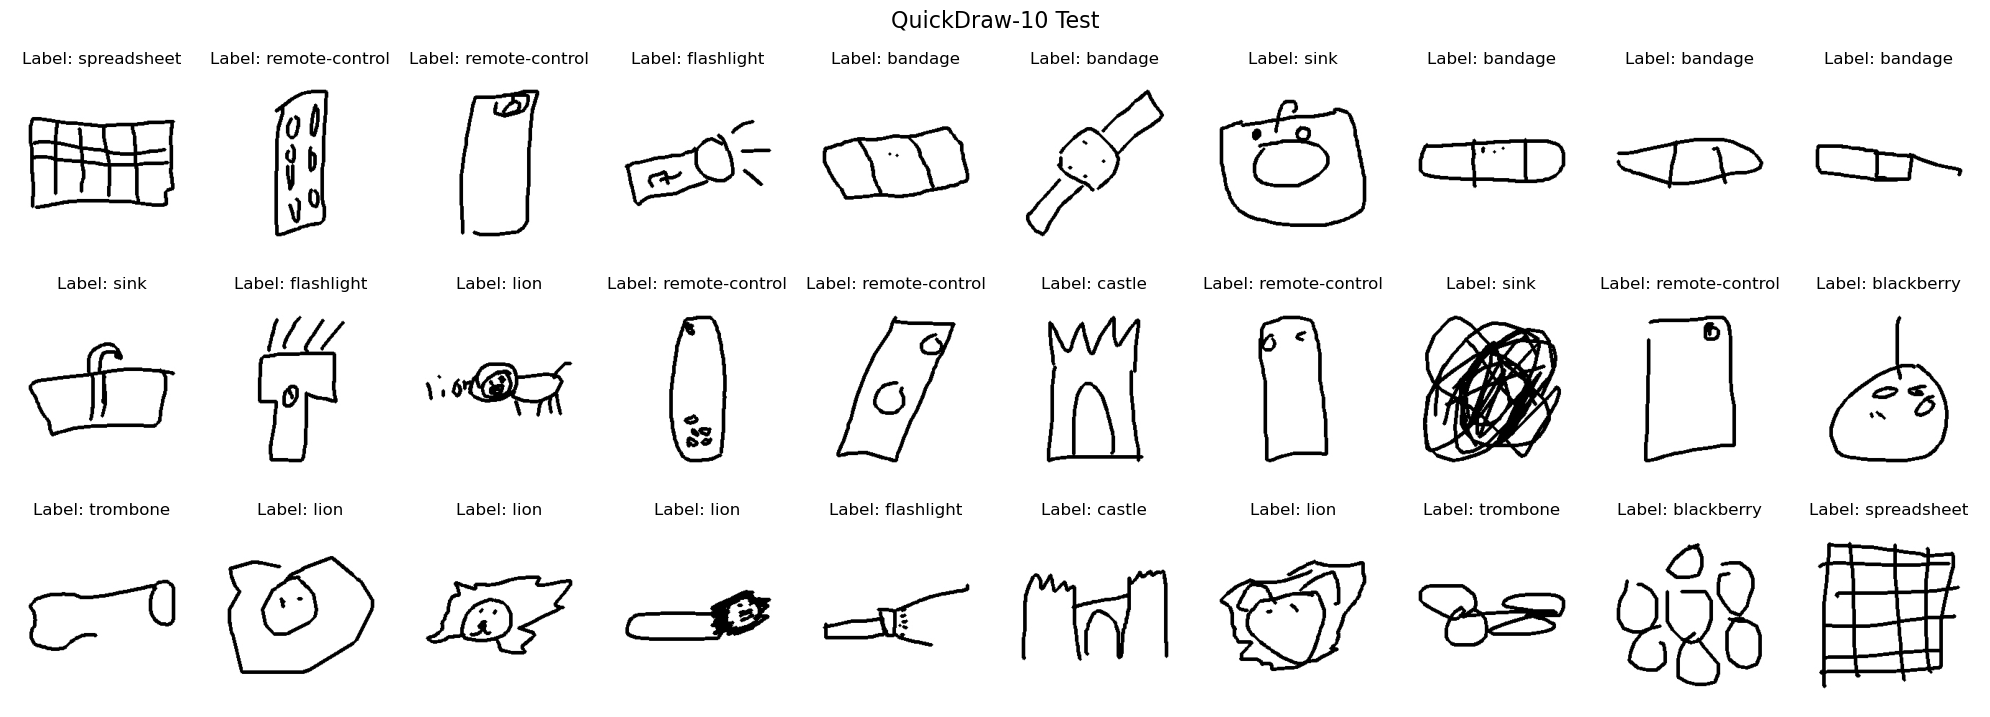

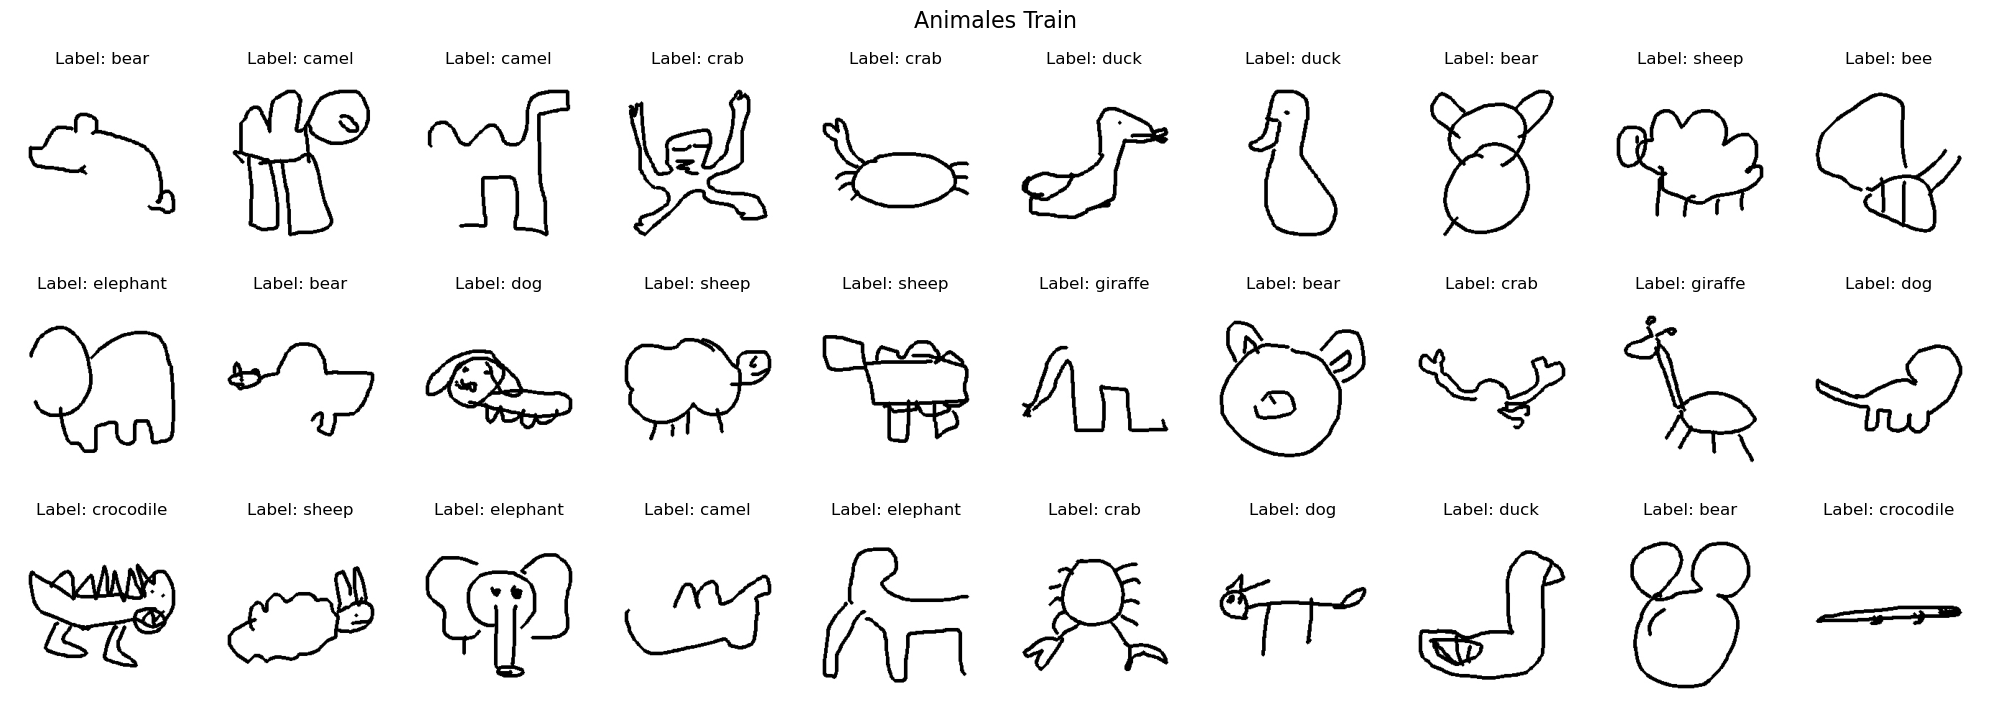

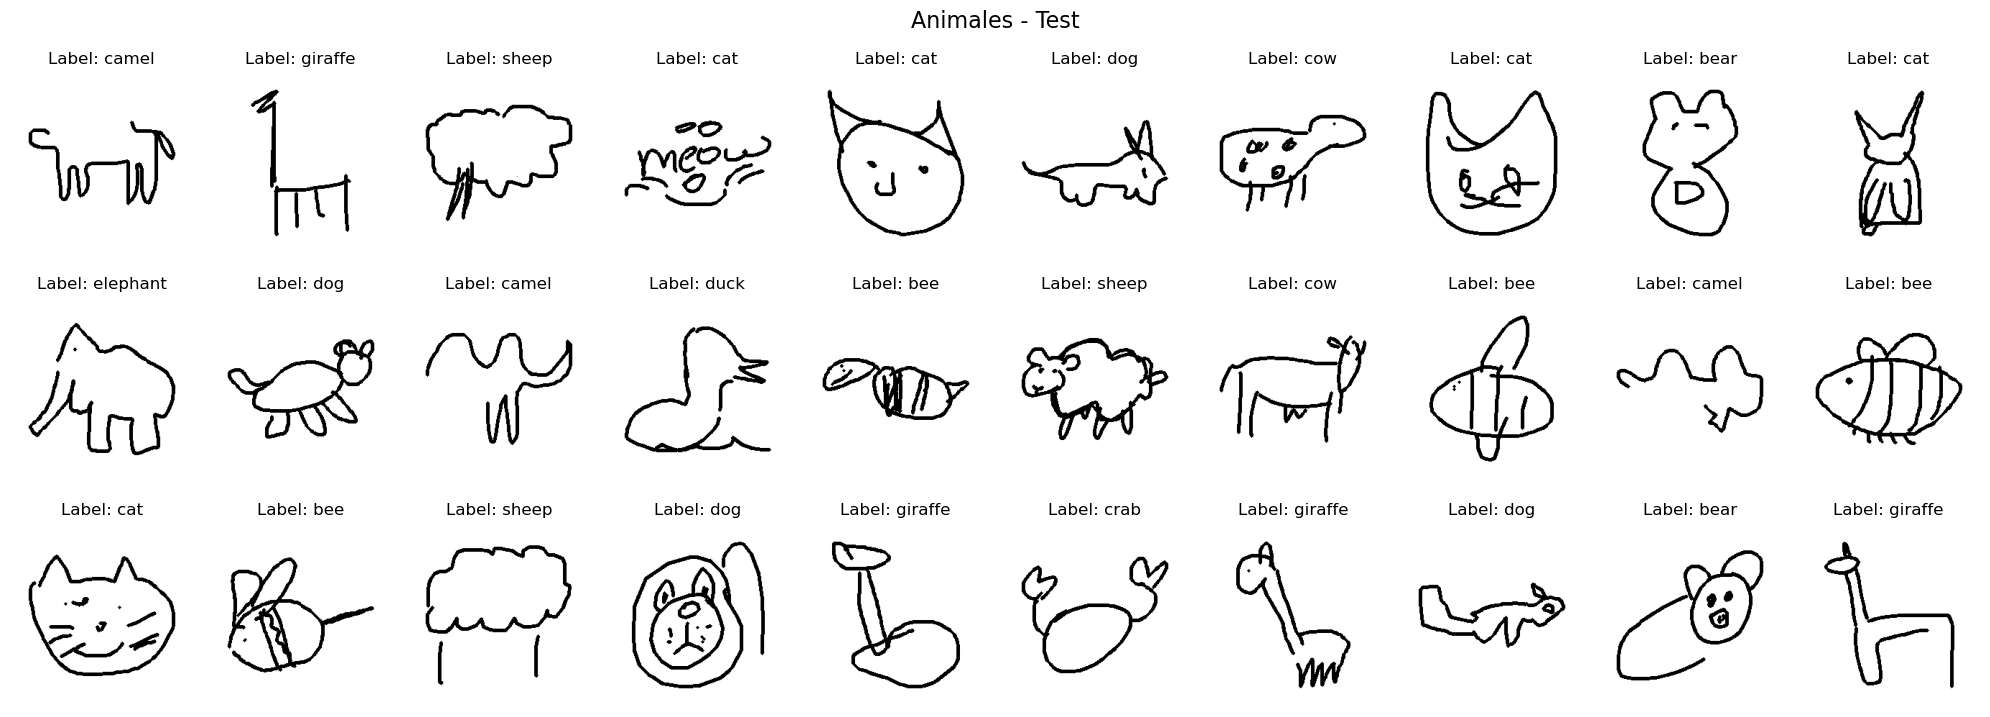

In [10]:
# Para QuickDraw-10
mostrar_imagenes_random(X_train10, y_train10, cantidad=30, etiquetas_dict=etiquetas_quickdraw10, titulo="QuickDraw-10 Train")
mostrar_imagenes_random(X_test10, y_test10, cantidad=30, etiquetas_dict=etiquetas_quickdraw10, titulo="QuickDraw-10 Test")

# Diccionario inverso para mostrar etiquetas
etiquetas_animals_inv = {v: k for k, v in etiquetas_animals.items()}
#  QuickDraw-Animals 
mostrar_imagenes_random(X_trainA, y_trainA, cantidad=30, etiquetas_dict=etiquetas_animals_inv, titulo="Animales Train")
mostrar_imagenes_random(X_testA, y_testA, cantidad=30, etiquetas_dict=etiquetas_animals_inv, titulo="Animales - Test")



## Descripción de los Modelos MLP

# MLP1 - 2 capas ReLU + CrossEntropy
Modelo con dos capas ocultas de tamaño 256 y 128 neuronas, activación ReLU en ambas capas, y función de pérdida CrossEntropyLoss. Ideal para clasificación básica con buena capacidad de aprendizaje.

# MLP2 - 3 capas Tanh/ReLU + CrossEntropy
Modelo con tres capas ocultas de tamaños 512, 256 y 128 neuronas. Las funciones de activación son Tanh en la primera capa y ReLU en las dos siguientes. Usa CrossEntropyLoss para la clasificación, proporcionando más profundidad para capturar patrones complejos.

# MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss
Modelo más profundo con cuatro capas ocultas (256, 128, 64, 32 neuronas), combinando activaciones LeakyReLU, Tanh y ReLU. Utiliza NLLLoss como función de pérdida, por lo que la salida aplica LogSoftmax.

In [11]:
modelos = [
    {
        "hidden_layers": [256, 128],
        "activation_fns": [nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.CrossEntropyLoss,
        "nombre": "MLP1 - 2 capas ReLU + CrossEntropy"
    },
    {
        "hidden_layers": [512, 256, 128],
        "activation_fns": [nn.Tanh, nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.CrossEntropyLoss,
        "nombre": "MLP2 - 3 capas Tanh/ReLU + CrossEntropy"
    },
    {
        "hidden_layers": [256, 128, 64, 32],
        "activation_fns": [nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.NLLLoss,
        "nombre": "MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss"
    }
]


In [12]:
class MLP_general(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fns, output_size, use_logsoftmax=False):
        super().__init__()
        layers = []
        in_features = input_size
        for h, act_fn in zip(hidden_layers, activation_fns):
            layers.append(nn.Linear(in_features, h))
            layers.append(act_fn())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        if use_logsoftmax:
            layers.append(nn.LogSoftmax(dim=1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [24]:
def evaluar_varias_veces_general(X_train_np, y_train_np, X_test_np, y_test_np,
                                hidden_layers, activation_fns, loss_fn_class,
                                repeticiones=5, epochs=20, lr=0.001, batch_size=32, etiquetas=None,
                                use_logsoftmax=False):

    accuracies = []
    accuracies_por_clase = []
    matrices_conf = []

    input_size = X_train_np.shape[1]
    output_size = len(np.unique(y_train_np))

    X_train_all = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_all = torch.tensor(y_train_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    for i in range(repeticiones):
        model = MLP_general(input_size, hidden_layers, activation_fns, output_size, use_logsoftmax)
        criterion = loss_fn_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = torch.utils.data.TensorDataset(X_train_all, y_train_all)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            loop = trange(len(loader), desc=f"Iteración {i+1} Epoch {epoch+1}", leave=False)
            for j, (inputs, labels) in zip(loop, loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                acc = correct / total
                loop.set_postfix(accuracy=acc, loss=running_loss / (j + 1))

        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            preds = outputs.argmax(dim=1)
            acc_total = accuracy_score(y_test, preds)
            loss = criterion(outputs, y_test).item()
            matriz = confusion_matrix(y_test, preds)

        with np.errstate(divide='ignore', invalid='ignore'):
            clase_sum = matriz.sum(axis=0)
            clase_sum[clase_sum == 0] = 1
            acc_clase = matriz.diagonal() / clase_sum

        accuracies.append(acc_total)
        accuracies_por_clase.append(acc_clase)
        matrices_conf.append(matriz)

        print(f"\nIteración {i} - Accuracy Total: {acc_total:.4f} - Loss: {loss:.4f}")
        print(f"Accuracy por cada clase en Iteración {i} : {acc_clase}")
        print("-" * 80)

    acc_median = np.median(accuracies)
    acc_clase_median = np.nanmedian(np.array(accuracies_por_clase), axis=0)
    median_cm = np.nanmedian(np.array(matrices_conf), axis=0).astype(int)

    disp = ConfusionMatrixDisplay(confusion_matrix=median_cm, display_labels=etiquetas)
    disp.plot(xticks_rotation=45,cmap='Blues')
    plt.title("Matriz de Confusión Mediana")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    
    plt.figure(figsize=(10, 5))

    if etiquetas is None:
        clases = [str(i) for i in range(len(acc_clase_median))]
    elif isinstance(etiquetas, dict):
        # Si etiquetas es dict con formato {0: "nombre"}, creamos lista ordenada con index y nombre
        clases = [f"{k} - {etiquetas[k]}" for k in sorted(etiquetas.keys())]
    else:
        # Si etiquetas es lista o similar, creamos con índices
        clases = [f"{i} - {nombre}" for i, nombre in enumerate(etiquetas)]

    plt.bar(clases, acc_clase_median)
    plt.title("Accuracy por clase (mediana)")
    plt.xlabel("Clases")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    return accuracies, acc_median, acc_clase_median


## MLP 1,2 y 3 con Quickdraw-10


Entrenando MLP1 - 2 capas ReLU + CrossEntropy...



Iteración 0 - Accuracy Total: 0.7178 - Loss: 2.2098
Accuracy por cada clase en Iteración 0 : [0.78217822 0.71653543 0.66412214 0.78512397 0.69607843 0.67368421
 0.78448276 0.74015748 0.792      0.54545455]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7247 - Loss: 1.9786
Accuracy por cada clase en Iteración 1 : [0.66666667 0.81981982 0.71900826 0.83050847 0.6440678  0.68817204
 0.75423729 0.728      0.81967213 0.56190476]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7479 - Loss: 1.8139
Accuracy por cada clase en Iteración 2 : [0.68461538 0.76724138 0.82       0.88571429 0.73684211 0.72340426
 0.68613139 0.7578125  0.856      0.58974359]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7419 - Loss: 2.0971
Accuracy por cada clase en Iteración 3 : [0.734375   0.78151261 0.76068376 0.80555556 0.68316832 0.79310345
 0.81896552 0.81730769 0.7761194  0.52631579]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7161 - Loss: 2.2619
Accuracy por cada clase en Iteración 4 : [0.69117647 0.70731707 0.73873874 0.86538462 0.52941176 0.61864407
 0.82352941 0.81132075 0.84482759 0.6375    ]
--------------------------------------------------------------------------------


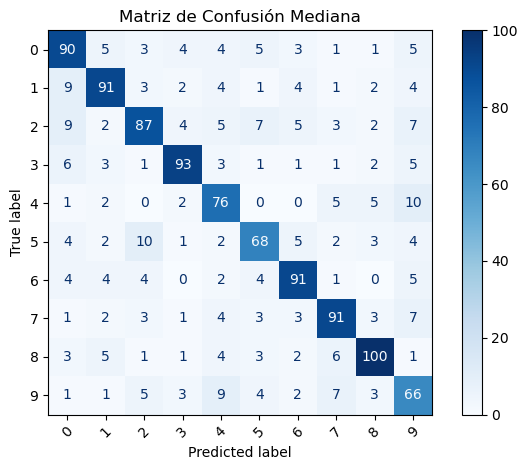

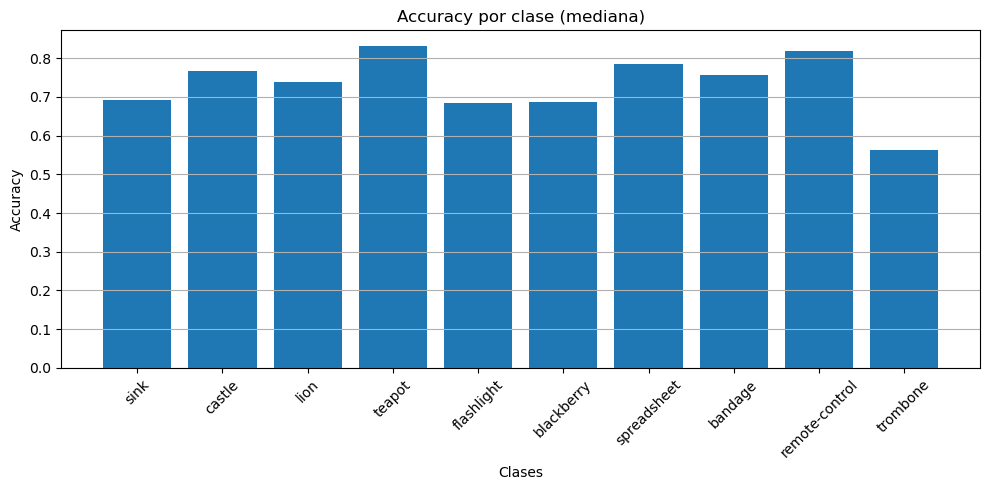

Mediana accuracy total MLP1 - 2 capas ReLU + CrossEntropy: 0.7247
Mediana accuracy por clase:
  Clase 0: 0.6912
  Clase 1: 0.7672
  Clase 2: 0.7387
  Clase 3: 0.8305
  Clase 4: 0.6832
  Clase 5: 0.6882
  Clase 6: 0.7845
  Clase 7: 0.7578
  Clase 8: 0.8197
  Clase 9: 0.5619

Entrenando MLP2 - 3 capas Tanh/ReLU + CrossEntropy...



Iteración 0 - Accuracy Total: 0.7075 - Loss: 1.9728
Accuracy por cada clase en Iteración 0 : [0.6350365  0.79310345 0.74226804 0.77391304 0.69811321 0.68041237
 0.70731707 0.69565217 0.8        0.55357143]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7230 - Loss: 2.0692
Accuracy por cada clase en Iteración 1 : [0.7265625  0.7480315  0.75268817 0.86666667 0.61029412 0.69473684
 0.67883212 0.77586207 0.74100719 0.65555556]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7136 - Loss: 2.3864
Accuracy por cada clase en Iteración 2 : [0.68148148 0.74796748 0.72477064 0.85849057 0.61870504 0.67708333
 0.7745098  0.75       0.7593985  0.55339806]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7101 - Loss: 2.2378
Accuracy por cada clase en Iteración 3 : [0.54945055 0.75454545 0.77419355 0.8411215  0.73958333 0.62931034
 0.76190476 0.7037037  0.78461538 0.67391304]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7144 - Loss: 1.9950
Accuracy por cada clase en Iteración 4 : [0.66176471 0.7107438  0.75247525 0.82608696 0.675      0.63478261
 0.75       0.80701754 0.81300813 0.52212389]
--------------------------------------------------------------------------------


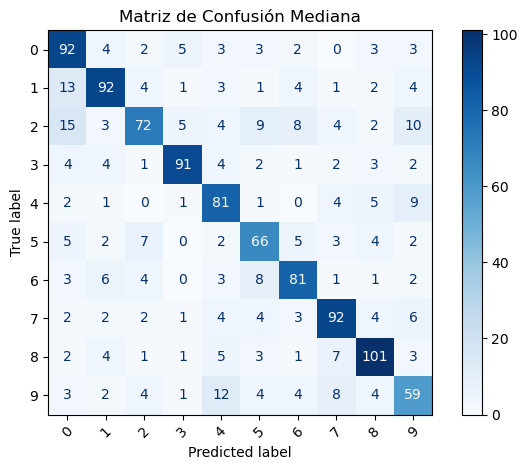

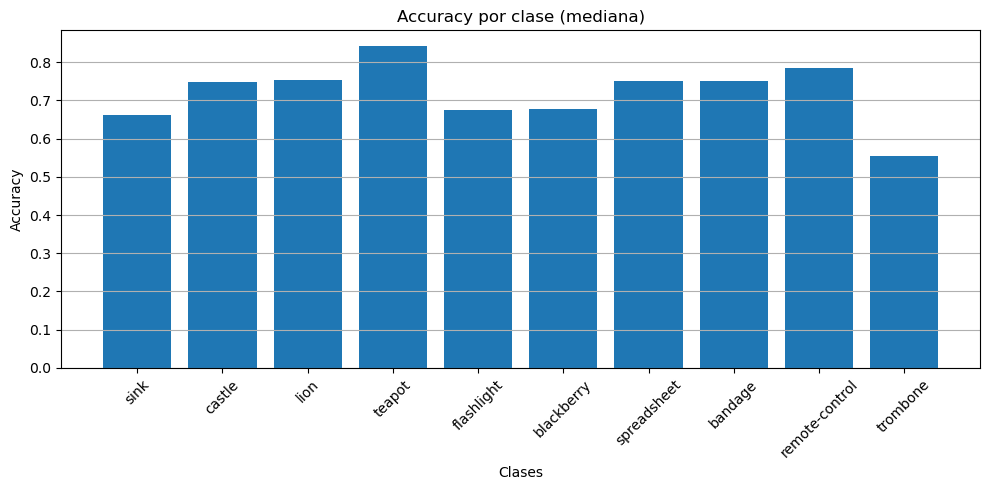

Mediana accuracy total MLP2 - 3 capas Tanh/ReLU + CrossEntropy: 0.7136
Mediana accuracy por clase:
  Clase 0: 0.6618
  Clase 1: 0.7480
  Clase 2: 0.7525
  Clase 3: 0.8411
  Clase 4: 0.6750
  Clase 5: 0.6771
  Clase 6: 0.7500
  Clase 7: 0.7500
  Clase 8: 0.7846
  Clase 9: 0.5536

Entrenando MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss...



Iteración 0 - Accuracy Total: 0.7110 - Loss: 1.9706
Accuracy por cada clase en Iteración 0 : [0.64052288 0.84466019 0.81914894 0.712      0.71111111 0.67010309
 0.76068376 0.70676692 0.74825175 0.53153153]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7007 - Loss: 1.9611
Accuracy por cada clase en Iteración 1 : [0.54597701 0.81052632 0.70731707 0.75700935 0.6015625  0.7029703
 0.76363636 0.84313725 0.7761194  0.59782609]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7213 - Loss: 1.7645
Accuracy por cada clase en Iteración 2 : [0.64925373 0.77319588 0.75630252 0.8034188  0.60689655 0.70526316
 0.82568807 0.70866142 0.86792453 0.58119658]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7204 - Loss: 1.8577
Accuracy por cada clase en Iteración 3 : [0.76363636 0.82882883 0.72881356 0.81481481 0.6779661  0.65486726
 0.77391304 0.74107143 0.79527559 0.47014925]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.6990 - Loss: 1.8527
Accuracy por cada clase en Iteración 4 : [0.69026549 0.76521739 0.65467626 0.7265625  0.60465116 0.75294118
 0.85714286 0.7107438  0.80327869 0.49593496]
--------------------------------------------------------------------------------


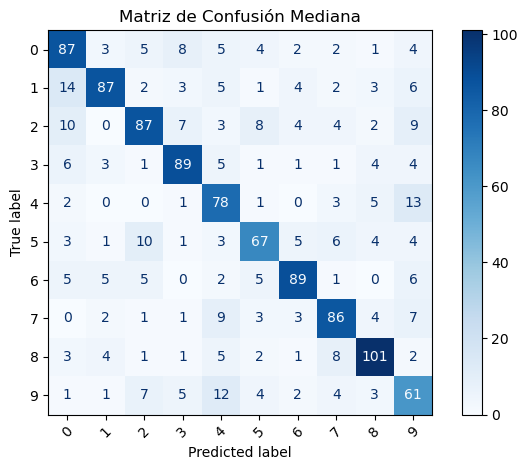

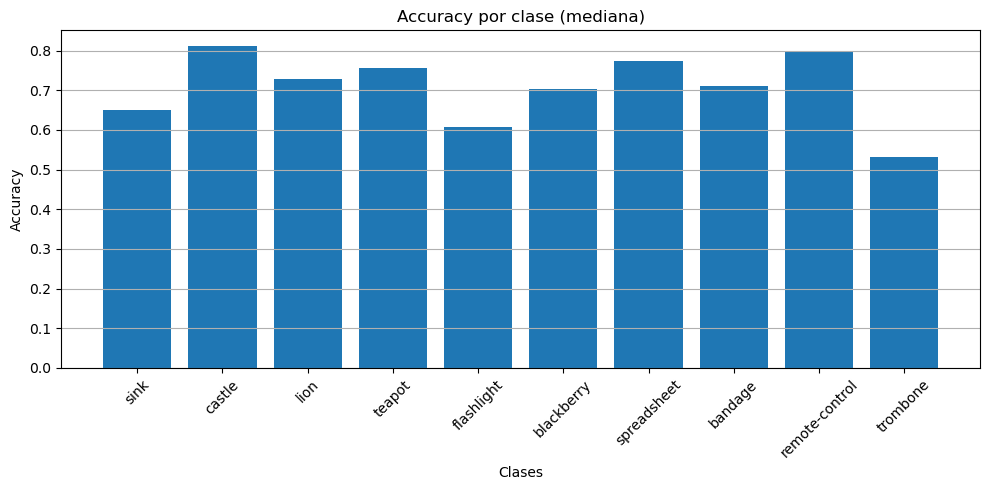

Mediana accuracy total MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss: 0.7110
Mediana accuracy por clase:
  Clase 0: 0.6493
  Clase 1: 0.8105
  Clase 2: 0.7288
  Clase 3: 0.7570
  Clase 4: 0.6069
  Clase 5: 0.7030
  Clase 6: 0.7739
  Clase 7: 0.7107
  Clase 8: 0.7953
  Clase 9: 0.5315


In [22]:
for modelo in modelos:
    print(f"\nEntrenando {modelo['nombre']}...")
    use_logsoftmax = modelo['loss_fn_class'] == nn.NLLLoss
    accs, mediana_acc, acc_clase_mediana = evaluar_varias_veces_general(
        X_train10_pca, y_train10, X_test10_pca, y_test10,
        hidden_layers=modelo['hidden_layers'],
        activation_fns=modelo['activation_fns'],
        loss_fn_class=modelo['loss_fn_class'],
        repeticiones=5,
        epochs=20,
        etiquetas=etiquetas_quickdraw10,
        use_logsoftmax=use_logsoftmax
    )
    print(f"Mediana accuracy total {modelo['nombre']}: {mediana_acc:.4f}")
    print("Mediana accuracy por clase:")
    for i, acc in enumerate(acc_clase_mediana):
        print(f"  Clase {i}: {acc:.4f}")


## MLP 1,2 y 3 con Quickdraw-Animals


Entrenando MLP1 - 2 capas ReLU + CrossEntropy en QuickDraw-Animals...


Iteración 1 Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]


Iteración 0 - Accuracy Total: 0.5106 - Loss: 4.4265
Accuracy por cada clase en Iteración 0 : [0.6196319  0.54676259 0.55238095 0.3976378  0.56084656 0.3800905
 0.47641509 0.74305556 0.54976303 0.44654088 0.2605364  0.75423729]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5256 - Loss: 4.1406
Accuracy por cada clase en Iteración 1 : [0.57142857 0.43867925 0.51627907 0.52071006 0.51485149 0.36909871
 0.52252252 0.70114943 0.59677419 0.46889952 0.27096774 0.80188679]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5081 - Loss: 4.4168
Accuracy por cada clase en Iteración 2 : [0.51515152 0.50292398 0.49576271 0.4        0.54594595 0.48120301
 0.46613546 0.60849057 0.50226244 0.50657895 0.23387097 0.68235294]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5069 - Loss: 4.2380
Accuracy por cada clase en Iteración 3 : [0.60377358 0.38867925 0.67763158 0.45098039 0.56       0.36546185
 0.51685393 0.67875648 0.51724138 0.47916667 0.24275362 0.85279188]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5165 - Loss: 4.2958
Accuracy por cada clase en Iteración 4 : [0.69736842 0.44651163 0.51886792 0.52564103 0.53768844 0.42696629
 0.49565217 0.74172185 0.58235294 0.42553191 0.24324324 0.71900826]
--------------------------------------------------------------------------------


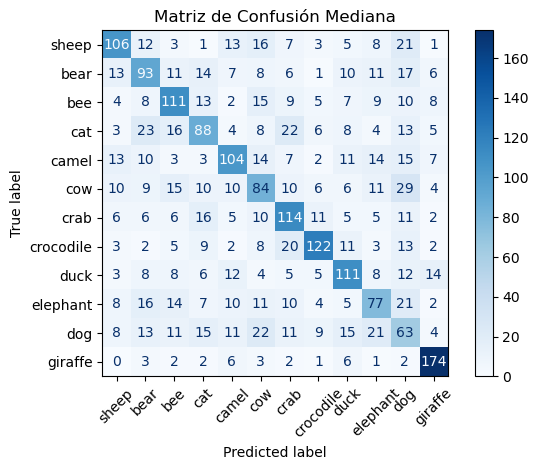

<Figure size 1000x500 with 0 Axes>

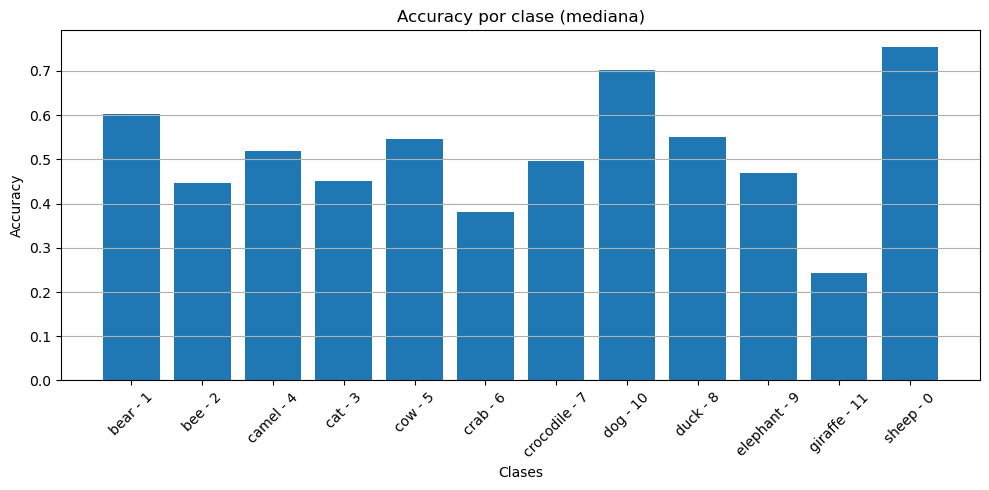

Mediana accuracy total MLP1 - 2 capas ReLU + CrossEntropy en QuickDraw-Animals: 0.5106
Mediana accuracy por clase:
  Clase 0: 0.6038
  Clase 1: 0.4465
  Clase 2: 0.5189
  Clase 3: 0.4510
  Clase 4: 0.5459
  Clase 5: 0.3801
  Clase 6: 0.4957
  Clase 7: 0.7011
  Clase 8: 0.5498
  Clase 9: 0.4689
  Clase 10: 0.2432
  Clase 11: 0.7542

Entrenando MLP2 - 3 capas Tanh/ReLU + CrossEntropy en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5148 - Loss: 4.0457
Accuracy por cada clase en Iteración 0 : [0.7080292  0.44594595 0.55980861 0.44385027 0.51162791 0.39
 0.52358491 0.6372549  0.59509202 0.41666667 0.23451327 0.79545455]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5240 - Loss: 4.3915
Accuracy por cada clase en Iteración 1 : [0.54672897 0.45789474 0.58031088 0.48901099 0.57432432 0.35251799
 0.50212766 0.68786127 0.59574468 0.45454545 0.28104575 0.77118644]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5240 - Loss: 4.3930
Accuracy por cada clase en Iteración 2 : [0.58959538 0.45982143 0.55506608 0.64444444 0.53179191 0.34821429
 0.50212766 0.68508287 0.56451613 0.52348993 0.26171875 0.75      ]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5181 - Loss: 4.1116
Accuracy por cada clase en Iteración 3 : [0.53815261 0.375      0.56682028 0.50549451 0.55747126 0.42857143
 0.515      0.58050847 0.54314721 0.46376812 0.26388889 0.8115942 ]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5181 - Loss: 4.1424
Accuracy por cada clase en Iteración 4 : [0.53191489 0.53289474 0.53211009 0.49704142 0.48148148 0.40454545
 0.45275591 0.62944162 0.6641791  0.43373494 0.28205128 0.78318584]
--------------------------------------------------------------------------------


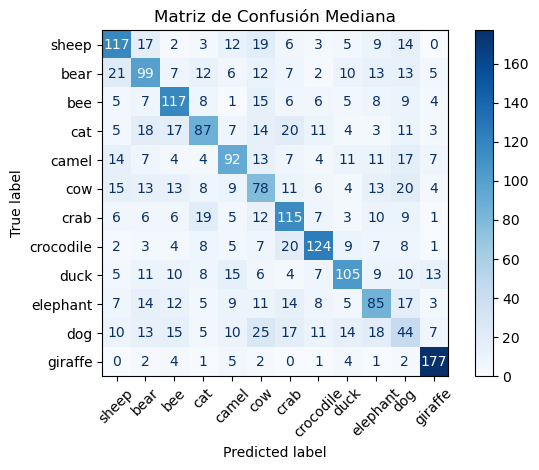

<Figure size 1000x500 with 0 Axes>

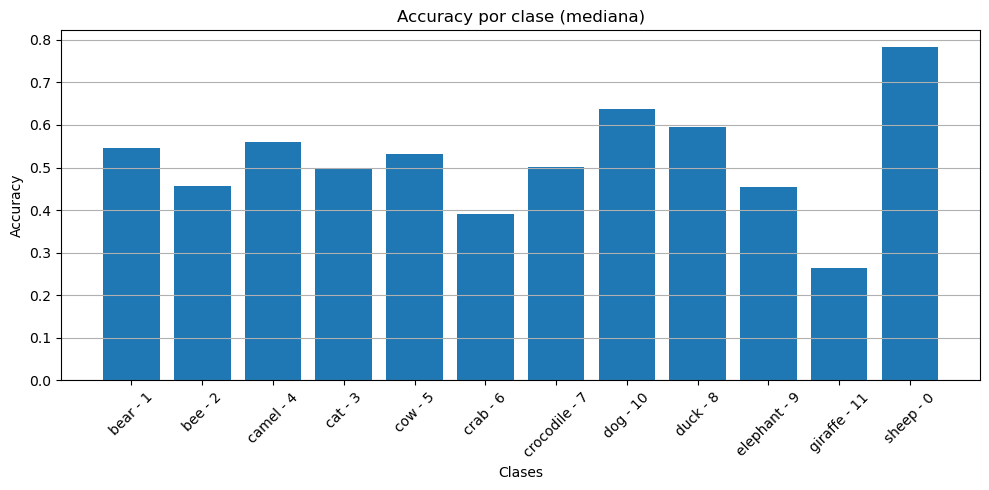

Mediana accuracy total MLP2 - 3 capas Tanh/ReLU + CrossEntropy en QuickDraw-Animals: 0.5181
Mediana accuracy por clase:
  Clase 0: 0.5467
  Clase 1: 0.4579
  Clase 2: 0.5598
  Clase 3: 0.4970
  Clase 4: 0.5318
  Clase 5: 0.3900
  Clase 6: 0.5021
  Clase 7: 0.6373
  Clase 8: 0.5951
  Clase 9: 0.4545
  Clase 10: 0.2639
  Clase 11: 0.7832

Entrenando MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5131 - Loss: 3.4665
Accuracy por cada clase en Iteración 0 : [0.52118644 0.49681529 0.55837563 0.40201005 0.62251656 0.44594595
 0.5255102  0.59307359 0.52208835 0.40833333 0.24277457 0.76576577]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5185 - Loss: 3.3958
Accuracy por cada clase en Iteración 1 : [0.50592885 0.49       0.54672897 0.49411765 0.53757225 0.4122807
 0.52513966 0.62910798 0.53191489 0.48387097 0.24637681 0.80365297]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5194 - Loss: 3.5654
Accuracy por cada clase en Iteración 2 : [0.63580247 0.45238095 0.6        0.48447205 0.52173913 0.42307692
 0.56647399 0.69897959 0.51530612 0.43062201 0.2398524  0.74380165]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5081 - Loss: 3.6010
Accuracy por cada clase en Iteración 3 : [0.65269461 0.46919431 0.58293839 0.41752577 0.46629213 0.38277512
 0.46263345 0.81118881 0.50638298 0.57575758 0.21590909 0.79710145]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5077 - Loss: 3.6396
Accuracy por cada clase en Iteración 4 : [0.60893855 0.47701149 0.57142857 0.41463415 0.54761905 0.31899642
 0.52694611 0.66666667 0.50869565 0.50769231 0.26168224 0.79425837]
--------------------------------------------------------------------------------


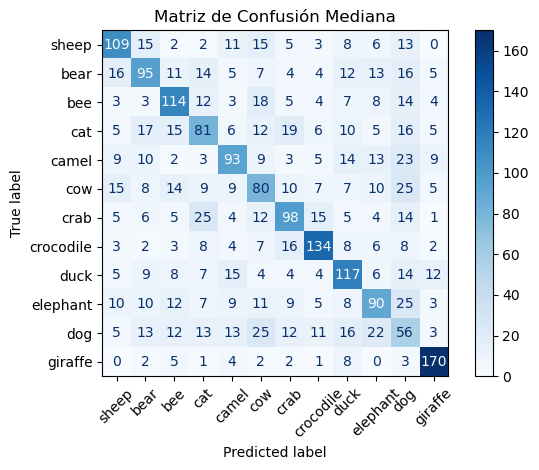

<Figure size 1000x500 with 0 Axes>

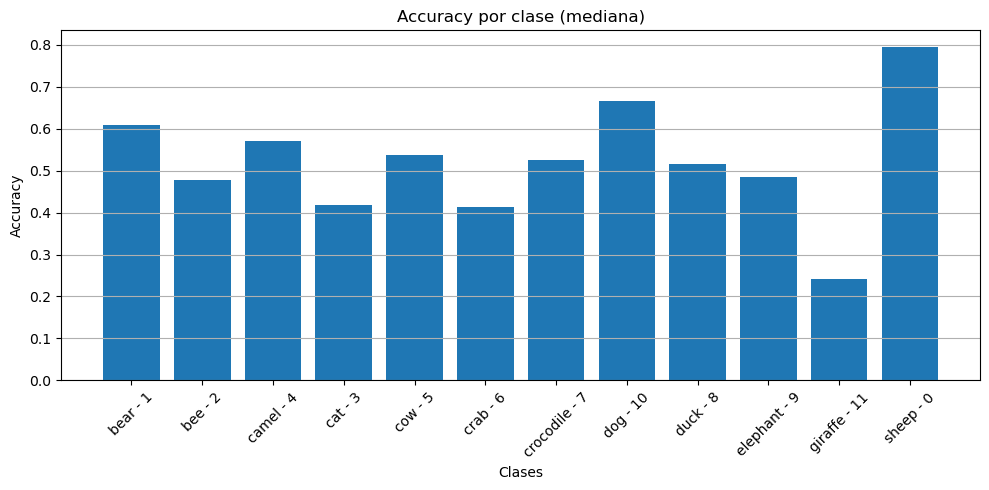

Mediana accuracy total MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss en QuickDraw-Animals: 0.5131
Mediana accuracy por clase:
  Clase 0: 0.6089
  Clase 1: 0.4770
  Clase 2: 0.5714
  Clase 3: 0.4175
  Clase 4: 0.5376
  Clase 5: 0.4123
  Clase 6: 0.5255
  Clase 7: 0.6667
  Clase 8: 0.5153
  Clase 9: 0.4839
  Clase 10: 0.2428
  Clase 11: 0.7943


In [27]:
for modelo in modelos:
    print(f"\nEntrenando {modelo['nombre']} en QuickDraw-Animals...")
    use_logsoftmax = modelo['loss_fn_class'] == nn.NLLLoss
    accs, mediana_acc, acc_clase_mediana = evaluar_varias_veces_general(
        X_trainA_pca, y_trainA, X_testA_pca, y_testA,
        hidden_layers=modelo['hidden_layers'],
        activation_fns=modelo['activation_fns'],
        loss_fn_class=modelo['loss_fn_class'],
        repeticiones=5,
        epochs=20,
        etiquetas=etiquetas_animals,
        use_logsoftmax=use_logsoftmax
    )
    print(f"Mediana accuracy total {modelo['nombre']} en QuickDraw-Animals: {mediana_acc:.4f}")
    print("Mediana accuracy por clase:")
    for i, acc in enumerate(acc_clase_mediana):
        print(f"  Clase {i}: {acc:.4f}")
